In [45]:
from pyspark.ml.clustering import KMeans
from kmodes.kmodes import KModes
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import dayofweek, dayofmonth, hour
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection
import numpy as np
import pandas as pd
import os

In [2]:
spark = SparkSession.builder.appName("Predict price").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/30 08:00:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/30 08:00:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
# Relative path
rel_path = "../TOMAS/projeto_principal/full_dataset_after_cleaning.parquet"

# Get absolute path
abs_path = os.path.abspath(rel_path)

# Load the dataset
data = spark.read.parquet(abs_path)

In [5]:
data.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- is_holiday: integer (nullable = true)
 |-- is_weekend: integer (nullable = true)
 |-- pickup_hour_decimal: double (nullable = true)

In [ ]:
df = data.withColumn("day", dayofmonth("tpep_pickup_datetime")) \
    .withColumn("hour", hour("tpep_pickup_datetime")) \
    .withColumn("day_of_week", dayofweek("tpep_pickup_datetime"))

# Select features for clustering
# You can add more like pickup_hour, day, etc.
features_to_use = ["trip_distance", 
               "total_amount", 
               "is_holiday", 
               "is_weekend", 
               "month", 
               #"day",
               "day_of_week",
               "hour", 
               "is_shared_ride",
               "Airport_fee",
               "has_toll",
               "has_congestion_fee"]

# Convert Spark DataFrame to Pandas
pandas_df = df.select(features_to_use).limit(100000).toPandas()

# # Assemble features into a single vector
# assembler = VectorAssembler(inputCols=features_to_use, outputCol="unscaled_features")

# # Scale features (important for KMeans to treat them fairly)
# scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withMean=True, withStd=True)

In [ ]:
df.select(["trip_distance", 'total_amount']).describe().show()

In [ ]:
# Discretize numerical columns into categories
pandas_df["distance_cat"] = pd.cut(pandas_df["trip_distance"], bins=[0, 1, 3, 6, np.inf], labels=["very_short", "short", "medium", "long"])
pandas_df["amount_cat"] = pd.cut(pandas_df["total_amount"], bins=[0, 15, 30, 60, np.inf], labels=["cheap", "moderate", "expensive", "very_expensive"])

In [43]:
pandas_df.groupby('amount_cat').count()

,trip_distance,total_amount,is_holiday,is_weekend,month,day_of_week,hour,is_shared_ride,Airport_fee,has_toll,has_congestion_fee,distance_cat
amount_cat,,,,,,,,,,,,
cheap,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883,16883
moderate,55792,55792,55792,55792,55792,55792,55792,55792,55792,55792,55792,55792
expensive,16755,16755,16755,16755,16755,16755,16755,16755,16755,16755,16755,16755
very_expensive,10570,10570,10570,10570,10570,10570,10570,10570,10570,10570,10570,10570


In [44]:
pandas_df.groupby('distance_cat').count()

,trip_distance,total_amount,is_holiday,is_weekend,month,day_of_week,hour,is_shared_ride,Airport_fee,has_toll,has_congestion_fee,amount_cat
distance_cat,,,,,,,,,,,,
very_short,23424,23424,23424,23424,23424,23424,23424,23424,23424,23424,23424,23424
short,47362,47362,47362,47362,47362,47362,47362,47362,47362,47362,47362,47362
medium,13558,13558,13558,13558,13558,13558,13558,13558,13558,13558,13558,13558
long,15656,15656,15656,15656,15656,15656,15656,15656,15656,15656,15656,15656


In [48]:
# Use only categorical columns
cat_df = pandas_df[pandas_df.columns[2:]].astype(str)

In [52]:
costs

[394165.0, 365395.0, 337845.0, 332519.0]

In [ ]:
costs = []
K = range(2, 5)  # Try k from 2 to 9

for k in K:
    km = KModes(n_clusters=k, init='Huang', n_init=3, verbose=0)
    km.fit(cat_df)
    costs.append(km.cost_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, costs, marker='o')
plt.title('Elbow Method for Optimal k (K-Modes)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

KeyboardInterrupt: 

In [53]:
# Create and fit K-Modes model
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=1)
clusters = km.fit_predict(cat_df)

# Attach cluster labels
pandas_df["cluster"] = clusters

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10042, cost: 382272.0
Run 1, iteration: 2/100, moves: 5, cost: 382272.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 12171, cost: 383114.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2949, cost: 386809.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 24857, cost: 382240.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 9722, cost: 386509.0
Best run was number 4


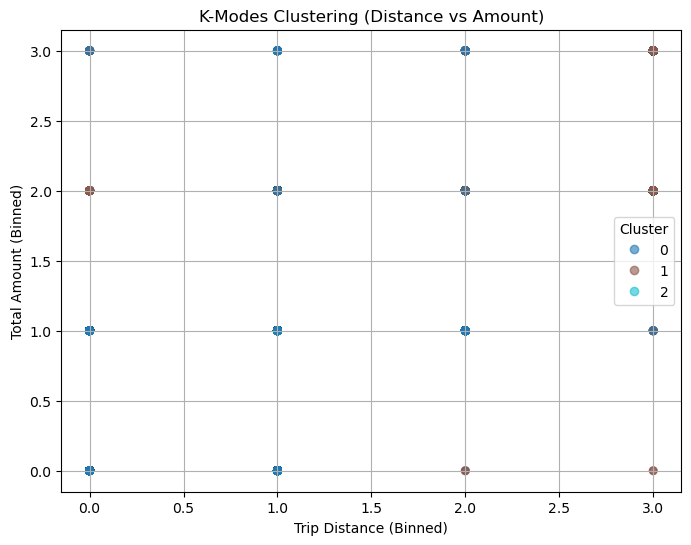

In [54]:
# Map binned categories to numeric values (if not already done)
distance_map = {'very_short': 0, 'short': 1, 'medium': 2, 'long': 3}
amount_map = {'cheap': 0, 'moderate': 1, 'expensive': 2, 'very_expensive': 3}

pandas_df["distance_num"] = pandas_df["distance_cat"].map(distance_map)
pandas_df["amount_num"] = pandas_df["amount_cat"].map(amount_map)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pandas_df["distance_num"],
    pandas_df["amount_num"],
    c=pandas_df["cluster"],
    cmap='tab10',
    s=30,
    alpha=0.6
)

plt.xlabel("Trip Distance (Binned)")
plt.ylabel("Total Amount (Binned)")
plt.title("K-Modes Clustering (Distance vs Amount)")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

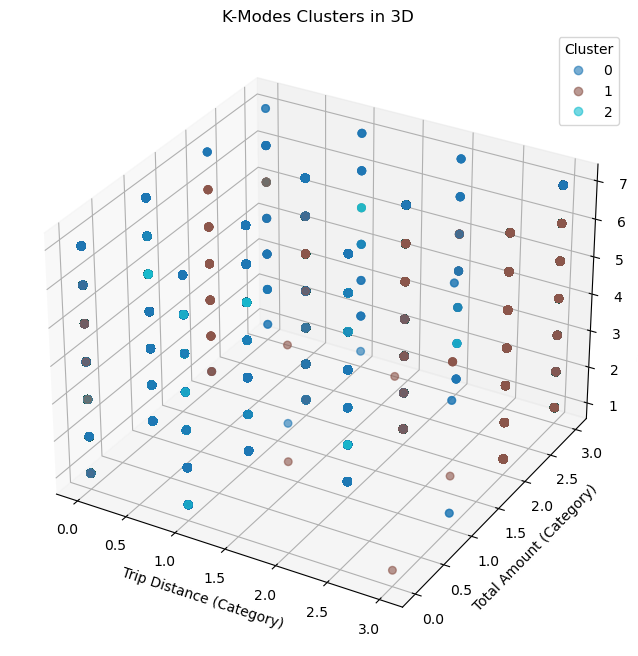

In [55]:
# Map categories to numeric values for 3D plotting
distance_map = {'very_short': 0, 'short': 1, 'medium': 2, 'long': 3}
amount_map = {'cheap': 0, 'moderate': 1, 'expensive': 2, 'very_expensive': 3}

pandas_df["distance_num"] = pandas_df["distance_cat"].map(distance_map)
pandas_df["amount_num"] = pandas_df["amount_cat"].map(amount_map)
pandas_df["day_of_week"] = pandas_df["day_of_week"].astype(int)

# 3D Scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pandas_df["distance_num"],
    pandas_df["amount_num"],
    pandas_df["day_of_week"],
    c=pandas_df["cluster"],
    cmap='tab10',
    alpha=0.6,
    s=30
)

ax.set_xlabel("Trip Distance (Category)")
ax.set_ylabel("Total Amount (Category)")
ax.set_zlabel("Day of Week (0=Mon)")
ax.set_title("K-Modes Clusters in 3D")

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

### Code for K means

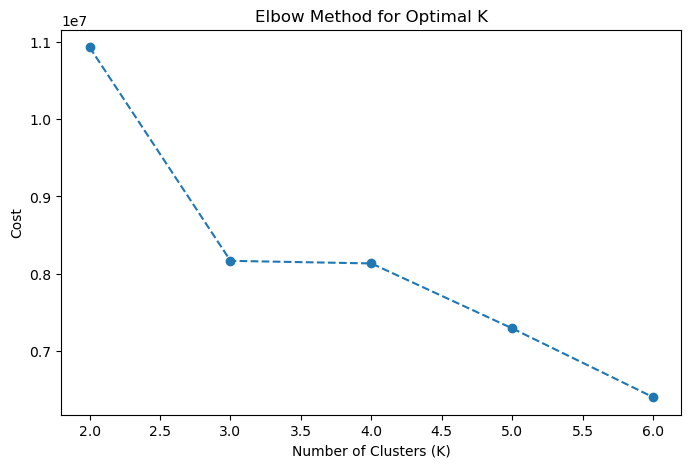

In [ ]:
# # Apply the Elbow Method to find optimal K
# df_elbow = df.limit(1000000)
# df_elbow = assembler.transform(df_elbow)
# my_scaler = scaler.fit(df_elbow)
# df_elbow = my_scaler.transform(df_elbow)

# cost = []
# k_values = range(2, 7)  # Testing k from 2 to 10

# for k in k_values:
#     kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=k, seed=1)
#     model = kmeans.fit(df_elbow)
#     cost.append(model.summary.trainingCost)

# # Plot Elbow Method
# plt.figure(figsize=(8, 5))
# plt.plot(k_values, cost, marker="o", linestyle="--")
# plt.xlabel("Number of Clusters (K)")
# plt.ylabel("Cost")
# plt.title("Elbow Method for Optimal K")
# plt.show()

In [ ]:
# Create KMeans model
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=42)

# Create pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

In [26]:
# Fit model
df_clustering = df.limit(100000)
model = pipeline.fit(df_clustering)

# Get clustered output
clustered_df = model.transform(df_clustering)

In [11]:
# Show sample results
clustered_df.select("trip_distance", "total_amount", "cluster").show(10)

+-------------+------------+-------+
|trip_distance|total_amount|cluster|
+-------------+------------+-------+
|          0.6|        12.1|      3|
|          8.5|       61.84|      1|
|         4.16|        31.8|      0|
|          2.0|        27.2|      3|
|         0.79|       14.64|      3|
|          2.9|        31.5|      3|
|         1.32|        15.8|      0|
|          3.1|        26.4|      3|
|         10.4|       84.49|      1|
|          3.2|       60.33|      1|
+-------------+------------+-------+
only showing top 10 rows



/var/folders/s7/s9wfpwyx2dj_9c9q_c07v03w0000gn/T/ipykernel_14318/2722854550.py:20: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(*scatter.legend_elements(), title="Cluster", labels=legend_labels)


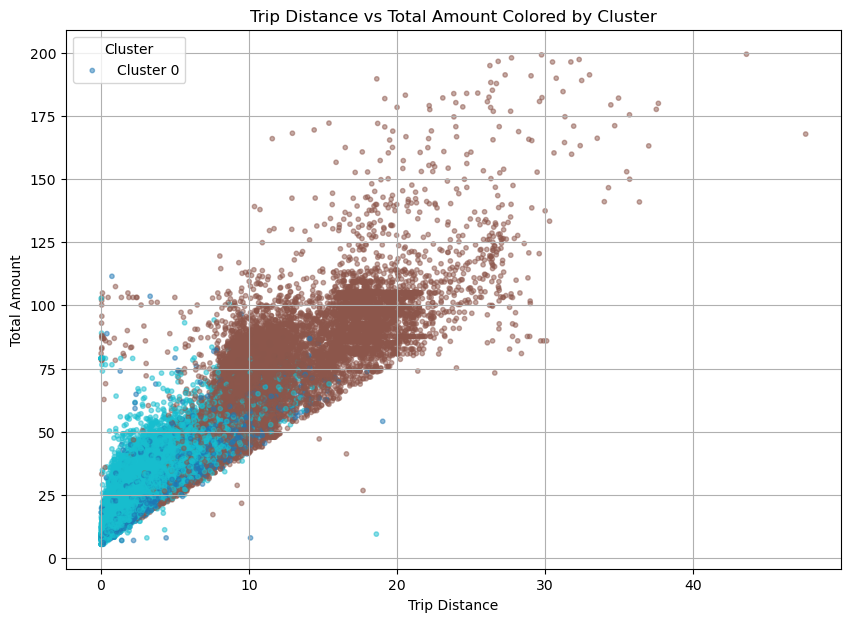

In [ ]:
pandas_df = clustered_df.select("trip_distance", "total_amount", "cluster") \
                        .limit(100000) \
                        .toPandas()

plt.figure(figsize=(10, 7))

# Scatter plot, color by cluster (matplotlib auto-assigns colors by integer)
scatter = plt.scatter(
    pandas_df['trip_distance'],
    pandas_df['total_amount'],
    c=pandas_df['cluster'],
    cmap='tab10',       # or 'viridis', 'Set1', etc.
    alpha=0.5,
    s=10
)

plt.xlabel("Trip Distance")
plt.ylabel("Total Amount")
plt.title("Trip Distance vs Total Amount Colored by Cluster")
plt.grid(True)

# Add legend with unique cluster labels
legend_labels = [f"Cluster {i}" for i in sorted(pandas_df['cluster'].unique())]
plt.legend(*scatter.legend_elements(), title="Cluster", labels=legend_labels)

plt.show()

/var/folders/s7/s9wfpwyx2dj_9c9q_c07v03w0000gn/T/ipykernel_14318/2005226349.py:27: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(*scatter.legend_elements(), title="Cluster", labels=legend_labels)


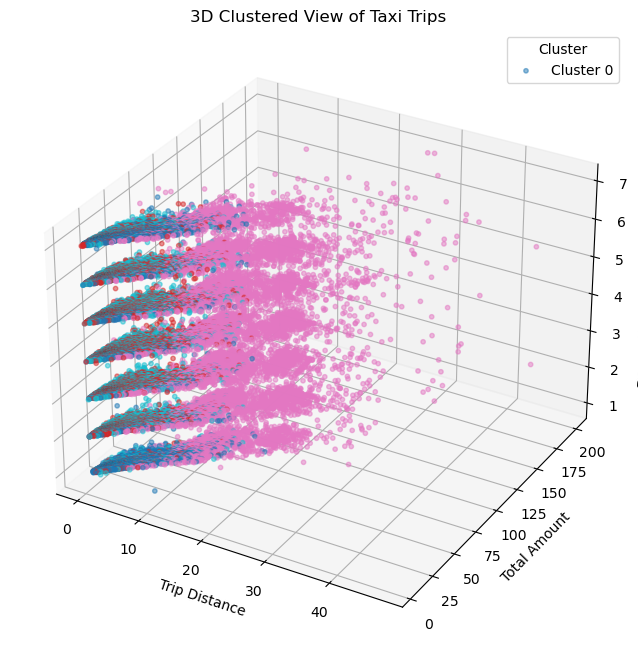

In [27]:
pandas_df = clustered_df.select(
    "trip_distance", "total_amount", "day_of_week", "cluster"
).limit(100000).toPandas()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot
scatter = ax.scatter(
    pandas_df['trip_distance'],
    pandas_df['total_amount'],
    pandas_df['day_of_week'],
    c=pandas_df['cluster'],
    cmap='tab10',
    alpha=0.5,
    s=10
)

# Axis labels
ax.set_xlabel('Trip Distance')
ax.set_ylabel('Total Amount')
ax.set_zlabel('Day of Week (1=Sun, 7=Sat)')
ax.set_title('3D Clustered View of Taxi Trips')

# Add cluster legend
legend_labels = [f"Cluster {i}" for i in sorted(pandas_df['cluster'].unique())]
plt.legend(*scatter.legend_elements(), title="Cluster", labels=legend_labels)

plt.show()